In [1]:
import ml_collections
import copy
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm
import os
import torch
import torch.nn as nn
from os import path as pt
import pickle
from torch.utils.data import DataLoader, TensorDataset
from src.evaluation.summary import full_evaluation
from src.utils import set_seed, save_obj, load_obj

In [2]:
with open("./data/ref_log_return.pkl", "rb") as f:
    loaded_array = pickle.load(f)
train_log_return = torch.tensor(loaded_array)
print(train_log_return.shape)

with open("./data/ref_price.pkl", "rb") as f:
    loaded_array = pickle.load(f)
train_init_price = torch.tensor(loaded_array)
print(train_init_price.shape)

torch.Size([8937, 24, 3])
torch.Size([8937, 1, 3])


### Generative models for time series generation

In [3]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
    
set_seed(config.seed)

if (config.device ==
        "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:0"}, allow_val_change=True)
else:
    config.update({"device": "cpu"}, allow_val_change=True)
    
class XYDataset(TensorDataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.shape = X.shape

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

### Data Construction

We divide the data into training and validation set for the offline evaluation of our model

In [4]:
perm_idx = torch.randperm(train_log_return.shape[0])
train_size = int(0.8*train_log_return.shape[0])

cv_training_data = train_log_return[perm_idx[:train_size]].to(config.device).to(torch.float)
cv_init_price = train_init_price[perm_idx[:train_size]].to(config.device).to(torch.float)
cv_validation_data = train_log_return[perm_idx[train_size:]].to(config.device).to(torch.float)
cv_val_init_price = train_init_price[perm_idx[train_size:]].to(config.device).to(torch.float)

In [5]:
# Load the dataset
training_set = TensorDataset(cv_init_price, cv_training_data)

train_dl = DataLoader(
    training_set,
    batch_size=config.batch_size,
    shuffle=True
)

config.input_dim = cv_training_data[0][0].shape[-1]

### Generative model

Here we construct a generator and a discriminator for this task. Both the generator and discriminator takes as input the time series. Then we have the training algorithm TailGANTrainer.

In [7]:
%load_ext autoreload

In [16]:
%autoreload 2
import src.baselines.networks.discriminators
import src.baselines.networks.generators
import src.baselines.TailGAN
Discriminator = src.baselines.networks.discriminators.Discriminator
Generator = src.baselines.networks.generators.Generator
TailGANTrainer = src.baselines.TailGAN.TailGANTrainer

In [ ]:
# Code for LSTM Generator
%autoreload 2
import testing_models.PCFGAN_main.src.networks.generators
LSTMGenerator = testing_models.PCFGAN_main.src.networks.generators.LSTMGenerator

### Initialize the generator, discriminator and the trainer

In [ ]:
# Run for standard Time-GAN
# generator = Generator(config)

# Run for Time-Gan with an LSTM generator
generator = LSTMGenerator(input_dim= 3,output_dim= 3,hidden_dim= 64,n_layers= 2)

discriminator = Discriminator(config)
trainer = TailGANTrainer(G=generator, D=discriminator,
                    train_dl=train_dl, batch_size=config.batch_size, n_gradient_steps=config.steps,
                    config=config)

### Model training and saving

In [ ]:
trainer.fit(config.device)
save_obj(trainer.G.state_dict(), './sample_submission_bundle/model_dict.pkl')

### Synthetic data generation

In [ ]:
g_state_dict = load_obj('./sample_submission_bundle/model_dict.pkl')

generator.load_state_dict(g_state_dict)

generator.eval()

eval_size = 1600

with torch.no_grad():
    fake_data = generator(batch_size = eval_size, device=config.device)
    
print(fake_data.shape)
# Save the data
save_obj(fake_data, './sample_submission_bundle/fake_log_return.pkl')

In [25]:
g_state_dict = load_obj('./sample_submission_bundle/model_dict.pkl')

lstmgenerator.load_state_dict(g_state_dict)

lstmgenerator.eval()

eval_size = 1600

with torch.no_grad():
    fake_data = lstmgenerator(batch_size = eval_size, n_lags=24, device=config.device)
    
print(fake_data.shape)
# Save the data
save_obj(fake_data, './sample_submission_bundle/fake_log_return.pkl')

torch.Size([1600, 24, 3])


0

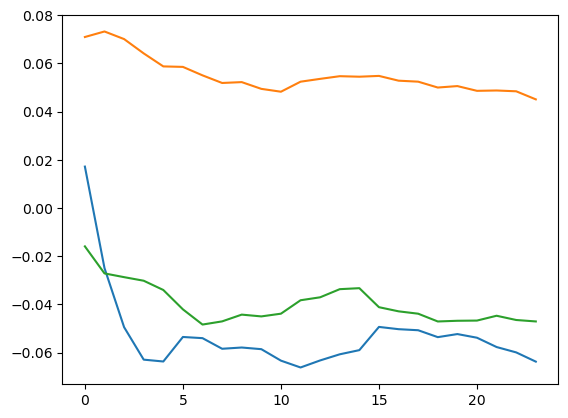

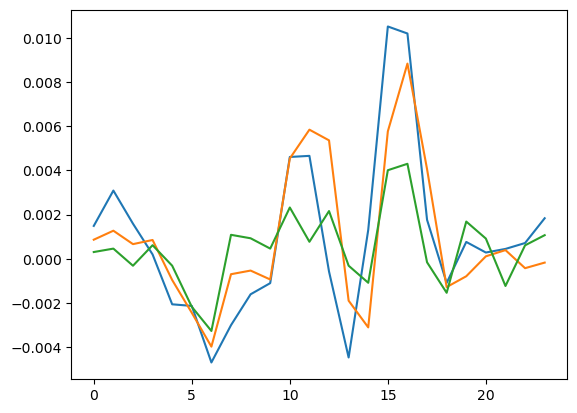

In [26]:
poiu = 5

copy_fake = fake_data.clone()
copy_fake = copy_fake.detach().cpu().numpy()
plt.plot(copy_fake[poiu,:,0])
plt.plot(copy_fake[poiu,:,1])
plt.plot(copy_fake[poiu,:,2])
plt.show()

copy_real = cv_validation_data.clone()
copy_real = copy_real.detach().cpu().numpy()
plt.plot(copy_real[poiu,:,0])
plt.plot(copy_real[poiu,:,1])
plt.plot(copy_real[poiu,:,2])
plt.show()

### Model evaluation

We compute the performance of our model by first generating the price process, apply the prespecified trading strategies and compare the resulting PnL process using the real and fake data.

In [27]:
from src.evaluation.strategies import log_return_to_price

config_dir = 'src/evaluation/config.yaml'
with open(config_dir) as file:
    eval_config = ml_collections.ConfigDict(yaml.safe_load(file))

fake_prices = log_return_to_price(fake_data[:eval_size], cv_val_init_price[:eval_size])
cv_val = log_return_to_price(cv_validation_data[:eval_size], cv_val_init_price[:eval_size])

all_positive = (fake_prices > 0).all()
if not all_positive:
    raise ValueError("Sanity Check Failed: Some fake prices are not positive.")

res_dict = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}

# Do final evaluation
num_strat = 4

with torch.no_grad():
    for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:
        subres_dict = full_evaluation(fake_prices, cv_val, eval_config, strat_name = strat_name)
        for k in res_dict:
            res_dict[k] += subres_dict[k] / num_strat
        
for k, v in res_dict.items():
    print(k, v)

var_mean 0.0798926098505035
es_mean 0.08249832130968571
max_drawback_mean 0.11918786633759737
cumulative_pnl_mean 0.22712379728909582
